In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.join(current_dir, '..', '..', '..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from sklearn.svm import OneClassSVM
from in2D.classifying.classes.simplex_tree_classifier import SimplexTreeClassifier
from in2D.classifying.classes.utilss.convexity_check import check_convexity, get_shared_vertices

In [2]:
def make_meshgrid(x, y, h=0.01):
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, xy, invert=False, use_decision_function=True, **params):
    if use_decision_function and hasattr(clf, 'decision_function'):
        Z = clf.decision_function(xy)
    else:
        Z = clf.predict(xy)
    if invert:
        Z = -Z
    Z = Z.reshape(xx.shape)
    return ax.contourf(xx, yy, Z, **params)

def plot_decision_boundary(ax, clf, xx, yy, xy, color='black', linewidth=2, linestyle='-'):
    """Draw the decision boundary line where decision_function = 0"""
    Z = clf.decision_function(xy)
    Z = Z.reshape(xx.shape)
    ax.contour(xx, yy, Z, levels=[0], colors=color, linewidths=linewidth, linestyles=linestyle)

## 1. Load Dataset

In [3]:
# Load triangle-optimized dataset (designed for triangular root simplex)
# Generated by generate_triangle_disconnected.py
data = np.load('../datasets/dataset_two_clusters_no_background.npz')
X, y = data['X'], data['y']

print(f"Dataset: {X.shape[0]} points, Classes: {np.unique(y)}")
print(f"Class distribution: {dict(zip(*np.unique(y, return_counts=True)))}")
print(f"Layout: Triangle - RED at bottom corners, BLUE at top + center band (separates the reds!)")

Dataset: 400 points, Classes: [1.]
Class distribution: {1.0: 400}
Layout: Triangle - RED at bottom corners, BLUE at top + center band (separates the reds!)


## 2. Build Model

In [4]:
C = 10000
root_vertices = [
    (0, 0),
    (2, 0),
    (0, 2)
]

subdivision_levels =6
model = SimplexTreeClassifier(
    vertices=root_vertices,
    classifier=OneClassSVM(kernel='linear', nu=0.1),
    subdivision_levels=subdivision_levels,
)
model.fit(X, y)

x_min, x_max = -0.05, 1.50
y_min, y_max = -0.05, 1.50
xx, yy = make_meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))

print(f"Model built with {len(model.leaf_simplexes)} leaf simplices")

Model built with 729 leaf simplices


## 3. Classification Shape BEFORE Any Removal

This shows the initial decision boundary with the full simplex tree subdivision.

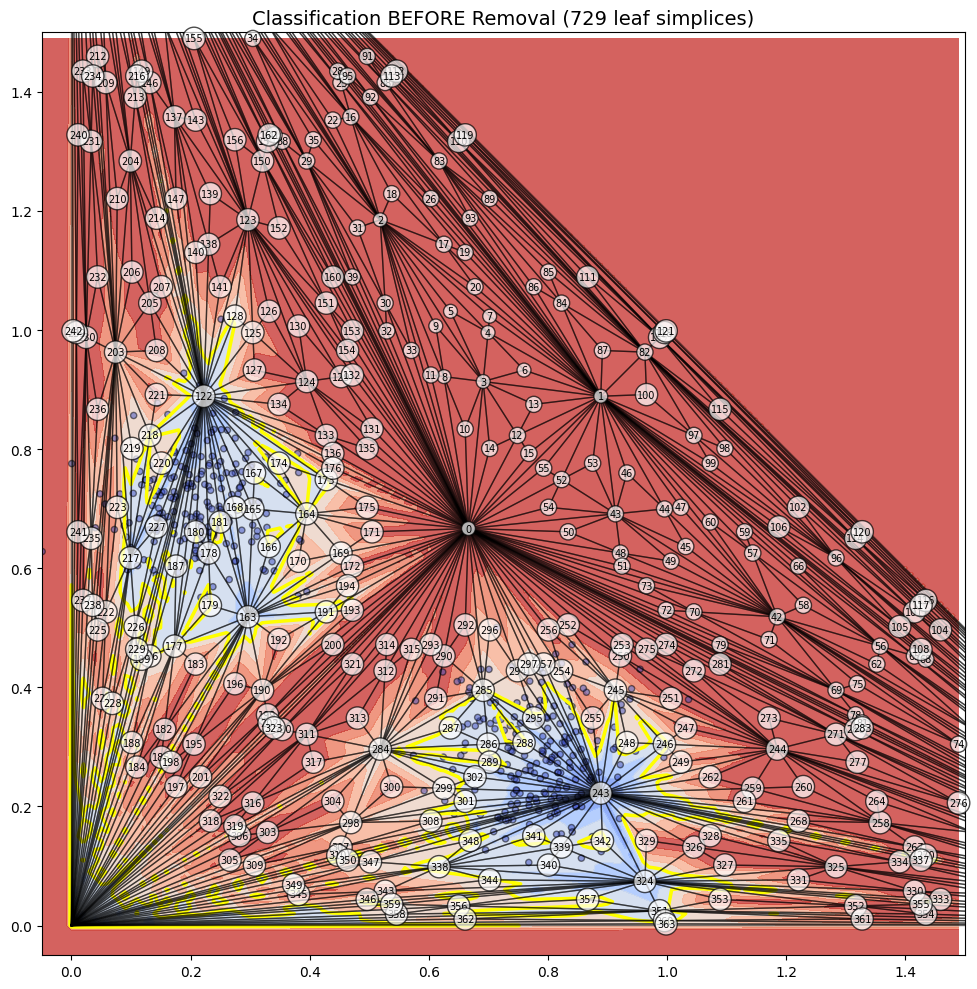

In [5]:
;# Classification shape BEFORE any removal
fig, ax = plt.subplots(figsize=(12, 10))

xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
plot_contours(ax, model.classifier, xx, yy, xy, invert=True, cmap=plt.cm.coolwarm, alpha=0.8)
plot_decision_boundary(ax, model.classifier, xx, yy, xy, color='yellow', linewidth=2.5)

# Draw simplex boundaries
for boundary in model.get_simplex_boundaries():
    if len(boundary) >= 3:
        closed = boundary + [boundary[0]]
        bx, by = zip(*closed)
        ax.plot(bx, by, 'k', linestyle='-', linewidth=1.0, alpha=0.5)

# Plot splitting point indices
for idx, center in model.tree.get_splitting_points():
    ax.annotate(str(idx), center, fontsize=7, ha='center', va='center', 
                bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', edgecolor='black', alpha=0.7), zorder=10)

# Scatter plot of data points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title(f"Classification BEFORE Removal ({len(model.leaf_simplexes)} leaf simplices)", fontsize=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## 4. Find Simplices to Remove

- **Non-convex**: Adjacent crossing simplices where the average point falls on wrong side
- **Same-side**: All siblings on same side of decision boundary

In [6]:
weights = model.classifier.coef_[0]
intercept = model.classifier.intercept_[0]
EPSILON = 0.30

nonconvex_simplex_keys = set()
crossing_simplices = model.identify_svm_crossing_simplices()

for i, info1 in enumerate(crossing_simplices):
    simplex1 = info1['simplex']
    for info2 in crossing_simplices[i+1:]:
        simplex2 = info2['simplex']
        shared = get_shared_vertices(simplex1, simplex2)
        if len(shared) >= 2:
            is_convex, avg, meeting, pt1, pt2 = check_convexity(
                simplex1, simplex2, weights, intercept,
                global_tree=model.tree, epsilon=EPSILON
            )
            if not is_convex:
                nonconvex_simplex_keys.add(frozenset(simplex1.vertex_indices))
                nonconvex_simplex_keys.add(frozenset(simplex2.vertex_indices))

same_side_simplex_keys = model.find_same_side_simplices()
combined_keys = nonconvex_simplex_keys.union(same_side_simplex_keys)

print(f"Non-convex simplices: {len(nonconvex_simplex_keys)}")
print(f"Same-side simplices: {len(same_side_simplex_keys)}")
print(f"Combined (union): {len(combined_keys)}")
print(f"Leaves before removal: {len(model.leaf_simplexes)}")

Non-convex simplices: 257
Same-side simplices: 414
Combined (union): 671
Leaves before removal: 729


## 5. Visualize and Remove

Shows side-by-side comparison:
- Left: Highlighted simplices marked for removal
- Right: Result after removal and refitting

Removed 242 simplices
Leaves after removal: 245


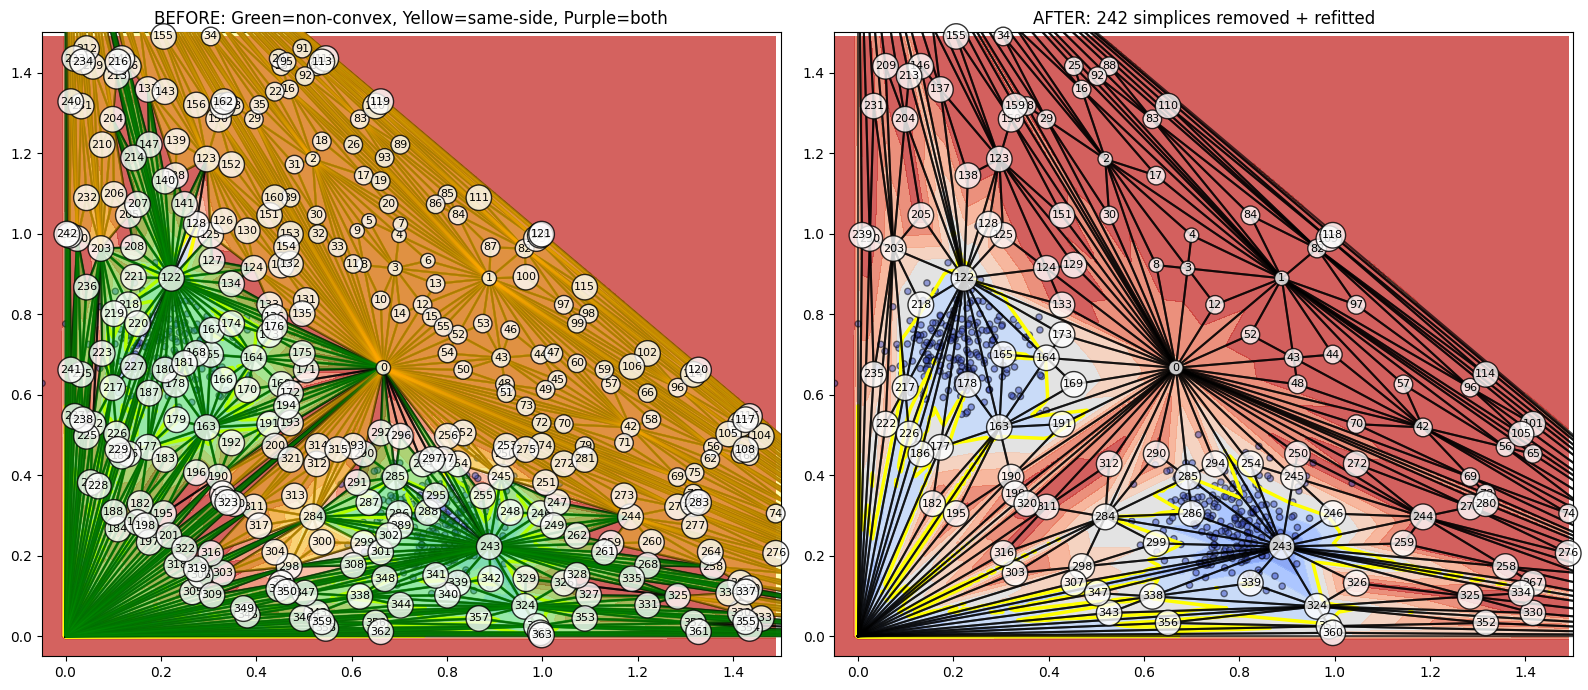

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# BEFORE removal
ax = axes[0]
xy_before = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
plot_contours(ax, model.classifier, xx, yy, xy_before, invert=True, cmap=plt.cm.coolwarm, alpha=0.8)
plot_decision_boundary(ax, model.classifier, xx, yy, xy_before, color='yellow', linewidth=2.5)
for boundary in model.get_simplex_boundaries():
    if len(boundary) >= 3:
        closed = boundary + [boundary[0]]
        bx, by = zip(*closed)
        ax.plot(bx, by, 'k', linestyle='-', linewidth=1.5, alpha=0.7)
for leaf in model.tree.get_leaves():
    simplex_key = frozenset(leaf.vertex_indices)
    is_nonconvex = simplex_key in nonconvex_simplex_keys
    is_same_side = simplex_key in same_side_simplex_keys
    if is_nonconvex and is_same_side:
        color, edge = 'purple', 'darkviolet'
    elif is_nonconvex:
        color, edge = 'lime', 'green'
    elif is_same_side:
        color, edge = 'yellow', 'orange'
    else:
        continue
    vertices = np.array(leaf.vertices)
    poly = patches.Polygon(vertices, closed=True, facecolor=color, alpha=0.3, edgecolor=edge, linewidth=2, zorder=6)
    ax.add_patch(poly)
for idx, center in model.tree.get_splitting_points():
    ax.annotate(str(idx), center, fontsize=8, ha='center', va='center', 
                bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8), zorder=10)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title("BEFORE: Green=non-convex, Yellow=same-side, Purple=both")

# Perform removal
removed_count = 0
for simplex_key in combined_keys:
    if model.tree.remove_by_leaf_key(simplex_key):
        removed_count += 1
model._build_node_lookup()
model.fit(X, y)
print(f"Removed {removed_count} simplices")
print(f"Leaves after removal: {len(model.tree.get_leaves())}")

# AFTER removal
ax = axes[1]
xy_after = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
plot_contours(ax, model.classifier, xx, yy, xy_after, invert=True, cmap=plt.cm.coolwarm, alpha=0.8)
plot_decision_boundary(ax, model.classifier, xx, yy, xy_after, color='yellow', linewidth=2.5)
for leaf in model.tree.get_leaves():
    vertices = leaf.get_vertices_as_tuples()
    if len(vertices) >= 3:
        closed = vertices + [vertices[0]]
        bx, by = zip(*closed)
        ax.plot(bx, by, 'k', linestyle='-', linewidth=1.5, alpha=0.7)
for idx, center in model.tree.get_splitting_points():
    ax.annotate(str(idx), center, fontsize=8, ha='center', va='center', 
                bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8), zorder=10)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title(f"AFTER: {removed_count} simplices removed + refitted")

plt.tight_layout()
plt.show()

In [8]:
model.tree.print_tree(show_only_splitting_points=False)

└── [0] vertices: [0, 1, 2]
    ├── [1] vertices: [1, 2, 3]
    │   ├── [2] vertices: [2, 3, 4]
    │   │   ├── [3] vertices: [3, 4, 5]
    │   │   │   ├── [4] vertices: [4, 5, 6]
    │   │   │   │   ├── vertices: [5, 6, 7]
    │   │   │   │   ├── vertices: [4, 6, 7]
    │   │   │   │   └── vertices: [4, 5, 7]
    │   │   │   ├── [8] vertices: [3, 5, 6]
    │   │   │   │   ├── vertices: [5, 6, 11]
    │   │   │   │   ├── vertices: [3, 6, 11]
    │   │   │   │   └── vertices: [3, 5, 11]
    │   │   │   └── [12] vertices: [3, 4, 6]
    │   │   │       ├── vertices: [4, 6, 15]
    │   │   │       ├── vertices: [3, 6, 15]
    │   │   │       └── vertices: [3, 4, 15]
    │   │   ├── [16] vertices: [2, 4, 5]
    │   │   │   ├── [17] vertices: [4, 5, 19]
    │   │   │   │   ├── vertices: [5, 19, 20]
    │   │   │   │   ├── vertices: [4, 19, 20]
    │   │   │   │   └── vertices: [4, 5, 20]
    │   │   │   ├── [21] vertices: [2, 5, 19]
    │   │   │   │   ├── vertices: [5, 19, 24]
    │   │   │

## 6. Iterative Removal

Reapply filters until no more simplices can be removed.

In [9]:
# Iteration 1
weights = model.classifier.coef_[0]
intercept = model.classifier.intercept_[0]

nonconvex_simplex_keys = set()
crossing_simplices = model.identify_svm_crossing_simplices()

for i, info1 in enumerate(crossing_simplices):
    simplex1 = info1['simplex']
    for info2 in crossing_simplices[i+1:]:
        simplex2 = info2['simplex']
        shared = get_shared_vertices(simplex1, simplex2)
        if len(shared) >= 2:
            is_convex, avg, meeting, pt1, pt2 = check_convexity(
                simplex1, simplex2, weights, intercept,
                global_tree=model.tree, epsilon=EPSILON
            )
            if not is_convex:
                nonconvex_simplex_keys.add(frozenset(simplex1.vertex_indices))
                nonconvex_simplex_keys.add(frozenset(simplex2.vertex_indices))

same_side_simplex_keys = model.find_same_side_simplices()
combined_keys = nonconvex_simplex_keys.union(same_side_simplex_keys)

print(f"Iteration 1:")
print(f"  Non-convex: {len(nonconvex_simplex_keys)}")
print(f"  Same-side: {len(same_side_simplex_keys)}")
print(f"  Combined: {len(combined_keys)}")

Iteration 1:
  Non-convex: 95
  Same-side: 120
  Combined: 215


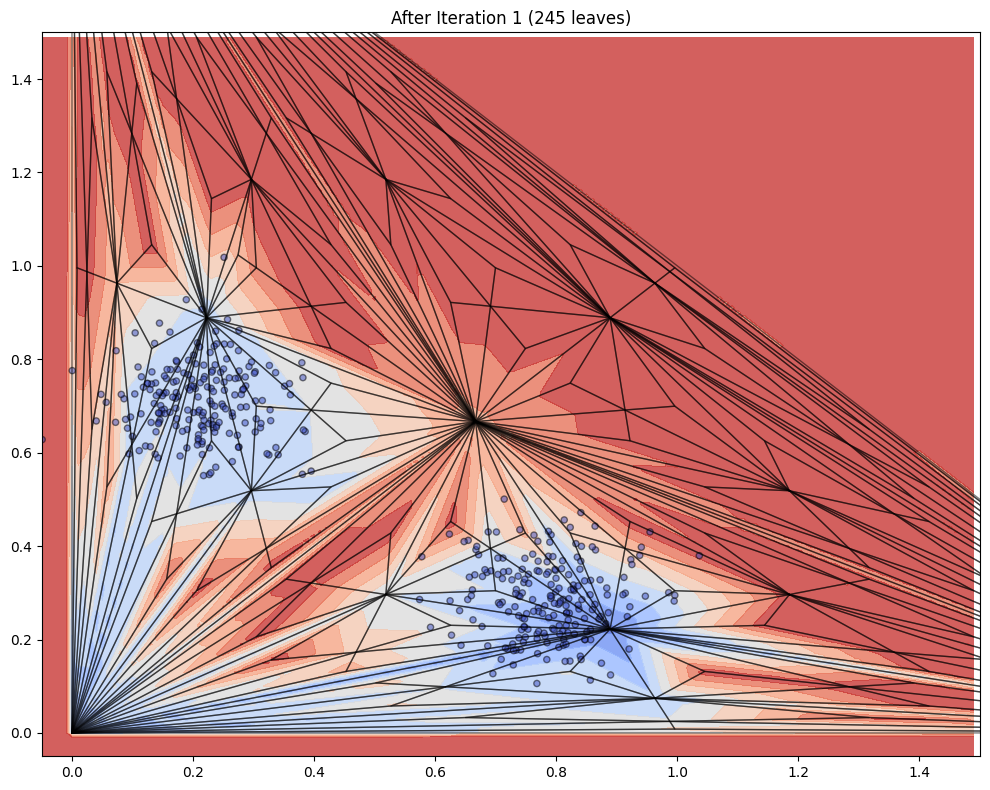

Removed 82 simplices, now 81 leaves


In [10]:
if len(combined_keys) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
    plot_contours(ax, model.classifier, xx, yy, xy, invert=True, cmap=plt.cm.coolwarm, alpha=0.8)
    for leaf in model.tree.get_leaves():
        vertices = leaf.get_vertices_as_tuples()
        if len(vertices) >= 3:
            closed = vertices + [vertices[0]]
            bx, by = zip(*closed)
            ax.plot(bx, by, 'k', linestyle='-', linewidth=1.0, alpha=0.5)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"After Iteration 1 ({len(model.tree.get_leaves())} leaves)")
    plt.tight_layout()
    plt.show()
    
    removed_count = 0
    for simplex_key in combined_keys:
        if model.tree.remove_by_leaf_key(simplex_key):
            removed_count += 1
    model._build_node_lookup()
    model.fit(X, y)
    print(f"Removed {removed_count} simplices, now {len(model.tree.get_leaves())} leaves")
else:
    print("No simplices to remove")

In [11]:
# Iteration 2
weights = model.classifier.coef_[0]
intercept = model.classifier.intercept_[0]

nonconvex_simplex_keys = set()
crossing_simplices = model.identify_svm_crossing_simplices()

for i, info1 in enumerate(crossing_simplices):
    simplex1 = info1['simplex']
    for info2 in crossing_simplices[i+1:]:
        simplex2 = info2['simplex']
        shared = get_shared_vertices(simplex1, simplex2)
        if len(shared) >= 2:
            is_convex, avg, meeting, pt1, pt2 = check_convexity(
                simplex1, simplex2, weights, intercept,
                global_tree=model.tree, epsilon=EPSILON
            )
            if not is_convex:
                nonconvex_simplex_keys.add(frozenset(simplex1.vertex_indices))
                nonconvex_simplex_keys.add(frozenset(simplex2.vertex_indices))

same_side_simplex_keys = model.find_same_side_simplices()
combined_keys = nonconvex_simplex_keys.union(same_side_simplex_keys)

print(f"Iteration 2:")
print(f"  Non-convex: {len(nonconvex_simplex_keys)}")
print(f"  Same-side: {len(same_side_simplex_keys)}")
print(f"  Combined: {len(combined_keys)}")

Iteration 2:
  Non-convex: 27
  Same-side: 33
  Combined: 60


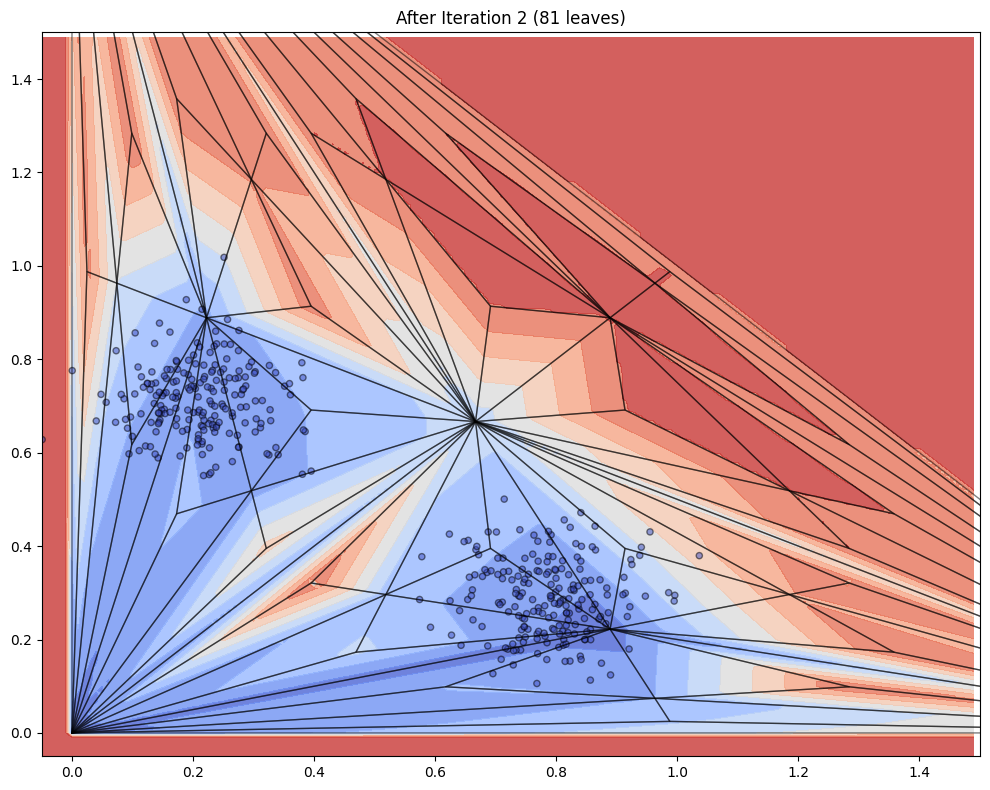

Removed 23 simplices, now 35 leaves


In [12]:
if len(combined_keys) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
    plot_contours(ax, model.classifier, xx, yy, xy, invert=True, cmap=plt.cm.coolwarm, alpha=0.8)
    for leaf in model.tree.get_leaves():
        vertices = leaf.get_vertices_as_tuples()
        if len(vertices) >= 3:
            closed = vertices + [vertices[0]]
            bx, by = zip(*closed)
            ax.plot(bx, by, 'k', linestyle='-', linewidth=1.0, alpha=0.5)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"After Iteration 2 ({len(model.tree.get_leaves())} leaves)")
    plt.tight_layout()
    plt.show()
    
    removed_count = 0
    for simplex_key in combined_keys:
        if model.tree.remove_by_leaf_key(simplex_key):
            removed_count += 1
    model._build_node_lookup()
    model.fit(X, y)
    print(f"Removed {removed_count} simplices, now {len(model.tree.get_leaves())} leaves")
else:
    print("No simplices to remove")

## 7. Final Result

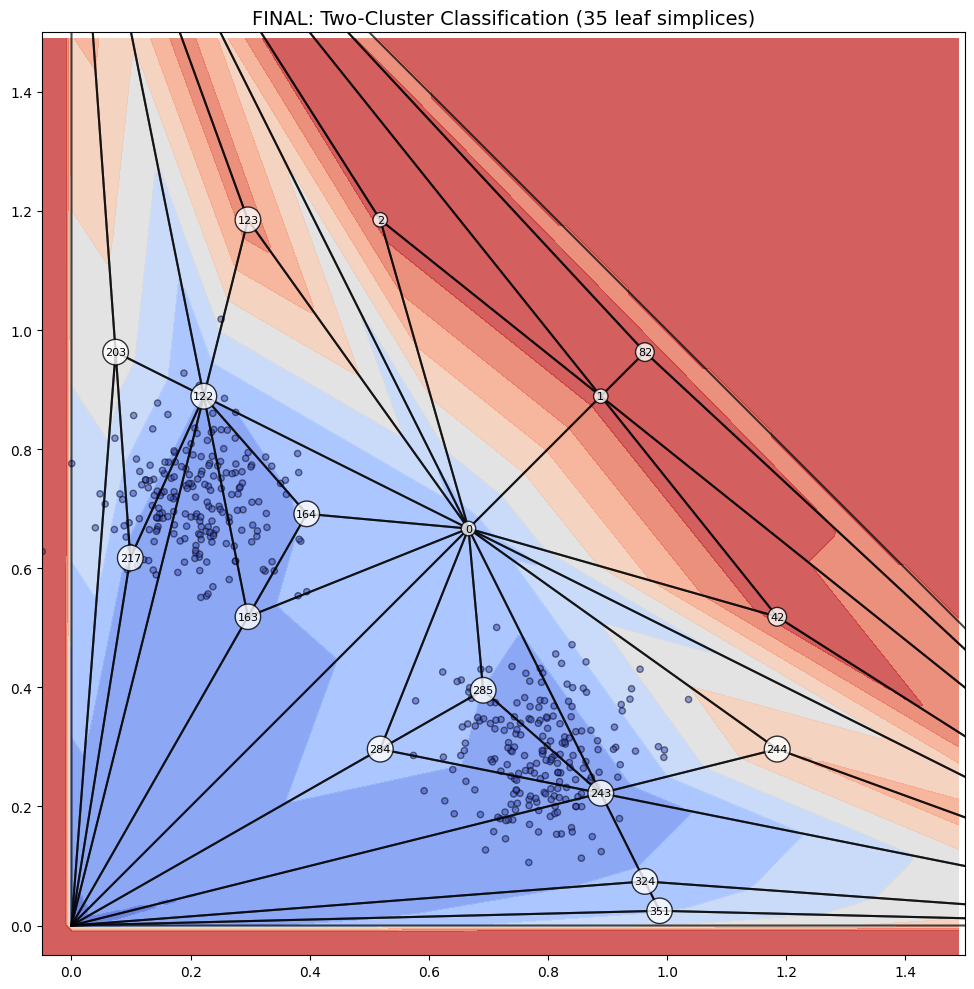

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))

xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
plot_contours(ax, model.classifier, xx, yy, xy, invert=True, cmap=plt.cm.coolwarm, alpha=0.8)

for leaf in model.tree.get_leaves():
    vertices = leaf.get_vertices_as_tuples()
    if len(vertices) >= 3:
        closed = vertices + [vertices[0]]
        bx, by = zip(*closed)
        ax.plot(bx, by, 'k', linestyle='-', linewidth=1.5, alpha=0.7)

for idx, center in model.tree.get_splitting_points():
    ax.annotate(str(idx), center, fontsize=8, ha='center', va='center', 
                bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8), zorder=10)

ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title(f"FINAL: Two-Cluster Classification ({len(model.tree.get_leaves())} leaf simplices)", fontsize=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [14]:
model.tree.print_tree(show_only_splitting_points=False)

└── [0] vertices: [0, 1, 2]
    ├── [1] vertices: [1, 2, 3]
    │   ├── [2] vertices: [2, 3, 4]
    │   │   ├── vertices: [3, 4, 5]
    │   │   ├── vertices: [2, 4, 5]
    │   │   └── vertices: [2, 3, 5]
    │   ├── [42] vertices: [1, 3, 4]
    │   │   ├── vertices: [3, 4, 45]
    │   │   ├── vertices: [1, 4, 45]
    │   │   └── vertices: [1, 3, 45]
    │   └── [82] vertices: [1, 2, 4]
    │       ├── vertices: [2, 4, 85]
    │       ├── vertices: [1, 4, 85]
    │       └── vertices: [1, 2, 85]
    ├── [122] vertices: [0, 2, 3]
    │   ├── [123] vertices: [2, 3, 125]
    │   │   ├── vertices: [3, 125, 126]
    │   │   ├── vertices: [2, 125, 126]
    │   │   └── vertices: [2, 3, 126]
    │   ├── [163] vertices: [0, 3, 125]
    │   │   ├── [164] vertices: [3, 125, 166]
    │   │   │   ├── vertices: [125, 166, 167]
    │   │   │   ├── vertices: [3, 166, 167]
    │   │   │   └── vertices: [3, 125, 167]
    │   │   ├── vertices: [0, 125, 166]
    │   │   └── vertices: [0, 3, 166]
    │   └─